In [1]:
# Importing necessary libraries

'''Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns

'''Data Handeling and Linear Algebra'''
import pandas as pd
import numpy as np

'''Manipulating Data and Model Building'''
import tensorflow as tf

'''Ignore warnings'''
import warnings
warnings.filterwarnings("ignore") 

In [2]:
# Take a look into the data
data=pd.read_csv("C:\\Users\\Dhairya Hindoriya\\OneDrive\\Desktop\\Sunspots Prediction\\data\\Sunspots.csv")
data

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7
...,...,...,...
3260,3260,2020-09-30,0.6
3261,3261,2020-10-31,14.4
3262,3262,2020-11-30,34.0
3263,3263,2020-12-31,21.8


In [3]:
data.tail()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
3260,3260,2020-09-30,0.6
3261,3261,2020-10-31,14.4
3262,3262,2020-11-30,34.0
3263,3263,2020-12-31,21.8
3264,3264,2021-01-31,10.4


In [4]:
data.info

<bound method DataFrame.info of       Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0              0  1749-01-31                               96.7
1              1  1749-02-28                              104.3
2              2  1749-03-31                              116.7
3              3  1749-04-30                               92.8
4              4  1749-05-31                              141.7
...          ...         ...                                ...
3260        3260  2020-09-30                                0.6
3261        3261  2020-10-31                               14.4
3262        3262  2020-11-30                               34.0
3263        3263  2020-12-31                               21.8
3264        3264  2021-01-31                               10.4

[3265 rows x 3 columns]>

In [5]:
data.describe()

,Unnamed: 0,Monthly Mean Total Sunspot Number
count,3265.000000,3265.000000
mean,1632.000000,81.778775
std,942.668641,67.889277
min,0.000000,0.000000
25%,816.000000,23.900000
50%,1632.000000,67.200000
75%,2448.000000,122.500000
max,3264.000000,398.200000


In [6]:
data.isnull().sum()

Unnamed: 0                           0
Date                                 0
Monthly Mean Total Sunspot Number    0
dtype: int64

In [7]:
# Last column ---> Sunspots data
sunspots = data.iloc[:,-1]
sunspots.values

array([ 96.7, 104.3, 116.7, ...,  34. ,  21.8,  10.4])

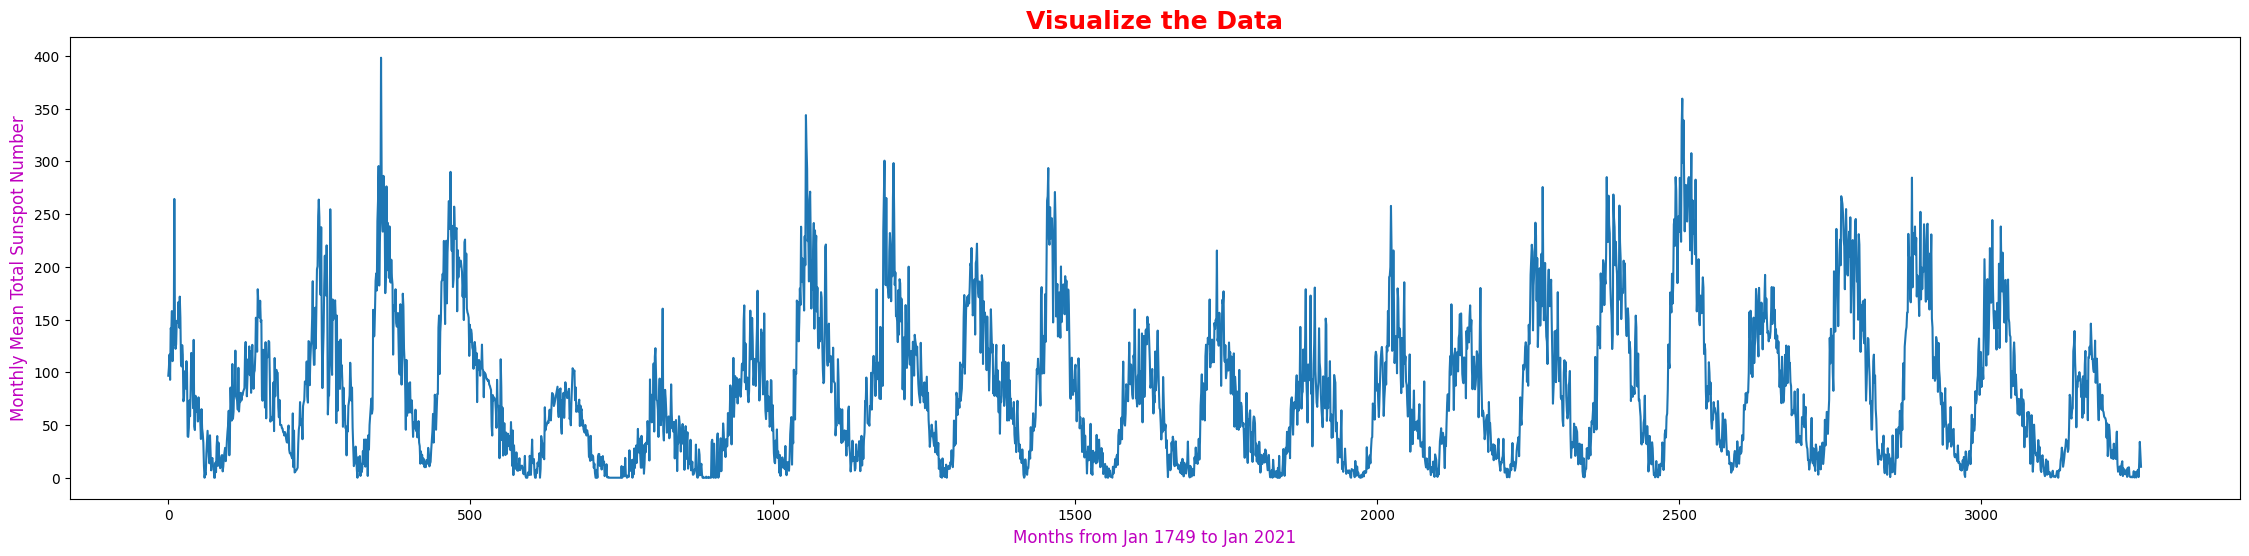

In [8]:
# Visualize the data
plt.figure(figsize=(28,6))
plt.plot(sunspots)
plt.ylabel(data.columns[-1], fontsize = 12, color = 'm')                     
plt.xlabel("Months from Jan 1749 to Jan 2021", fontsize = 12, color = 'm')
plt.title("Visualize the Data", fontsize = 18, color = 'r', weight = 'bold')
plt.show()

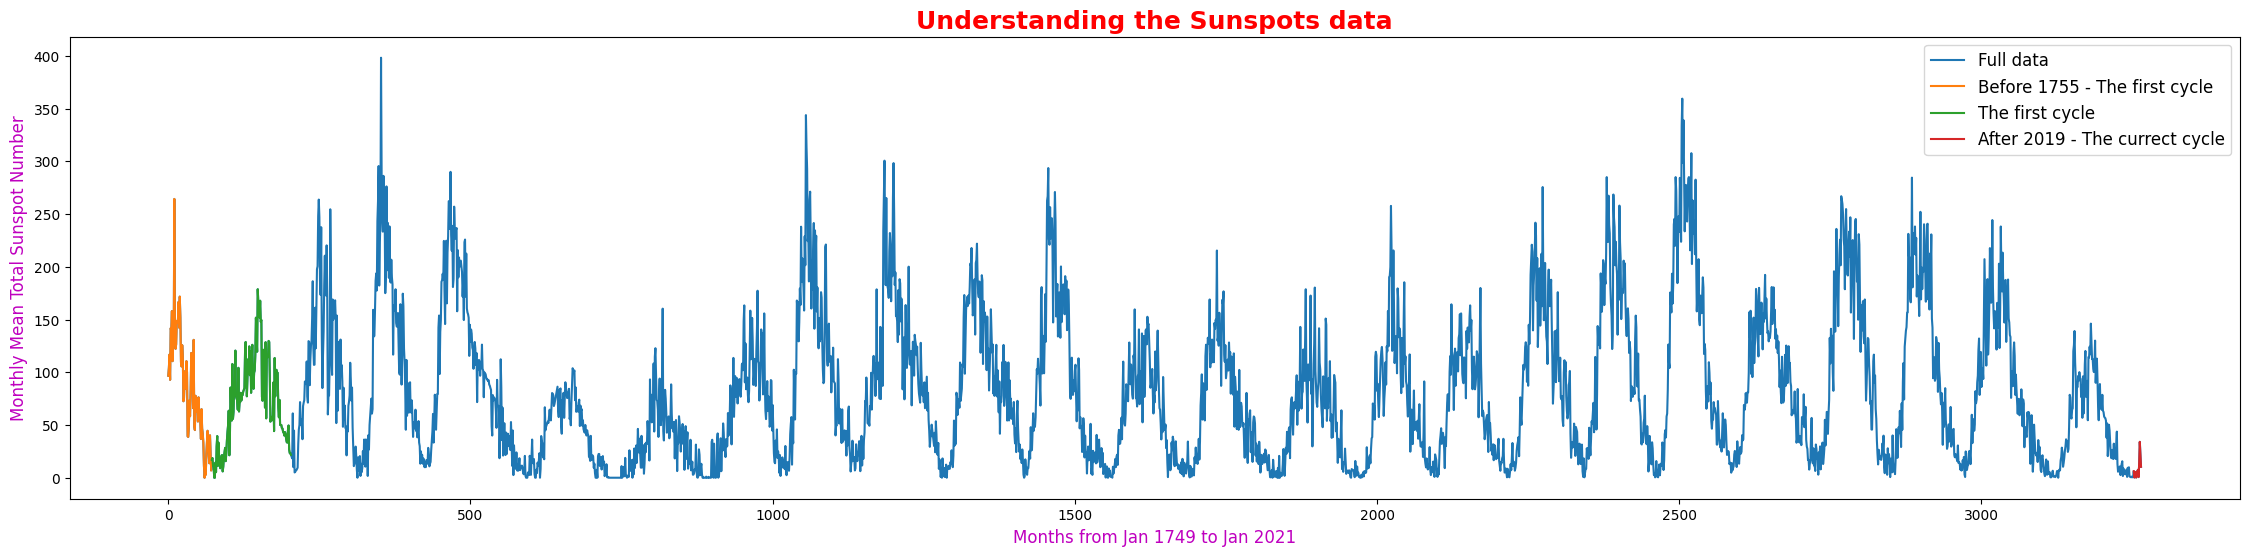

In [9]:
# Highlighting the above points in our visualization
'''Approx 11 years cycle ---> approx 132 months cycle'''
plt.figure(figsize=(28,6))
plt.plot(sunspots)            # The whole data
plt.plot(sunspots[:72])       # Data from 1749, actual cycles started from 1755 --> 6 years means 72 months
plt.plot(sunspots[72:72+132]) # Showing the first cycle 
plt.plot(sunspots[-13:])      # Displaying the current cycle
plt.ylabel(data.columns[-1], fontsize = 12, color = 'm')
plt.xlabel("Months from Jan 1749 to Jan 2021", fontsize = 12, color = 'm')
plt.title("Understanding the Sunspots data", fontsize = 18, color = 'r', weight = 'bold')
plt.legend(["Full data", "Before 1755 - The first cycle", "The first cycle", "After 2019 - The currect cycle"], fontsize = 12)
plt.show()

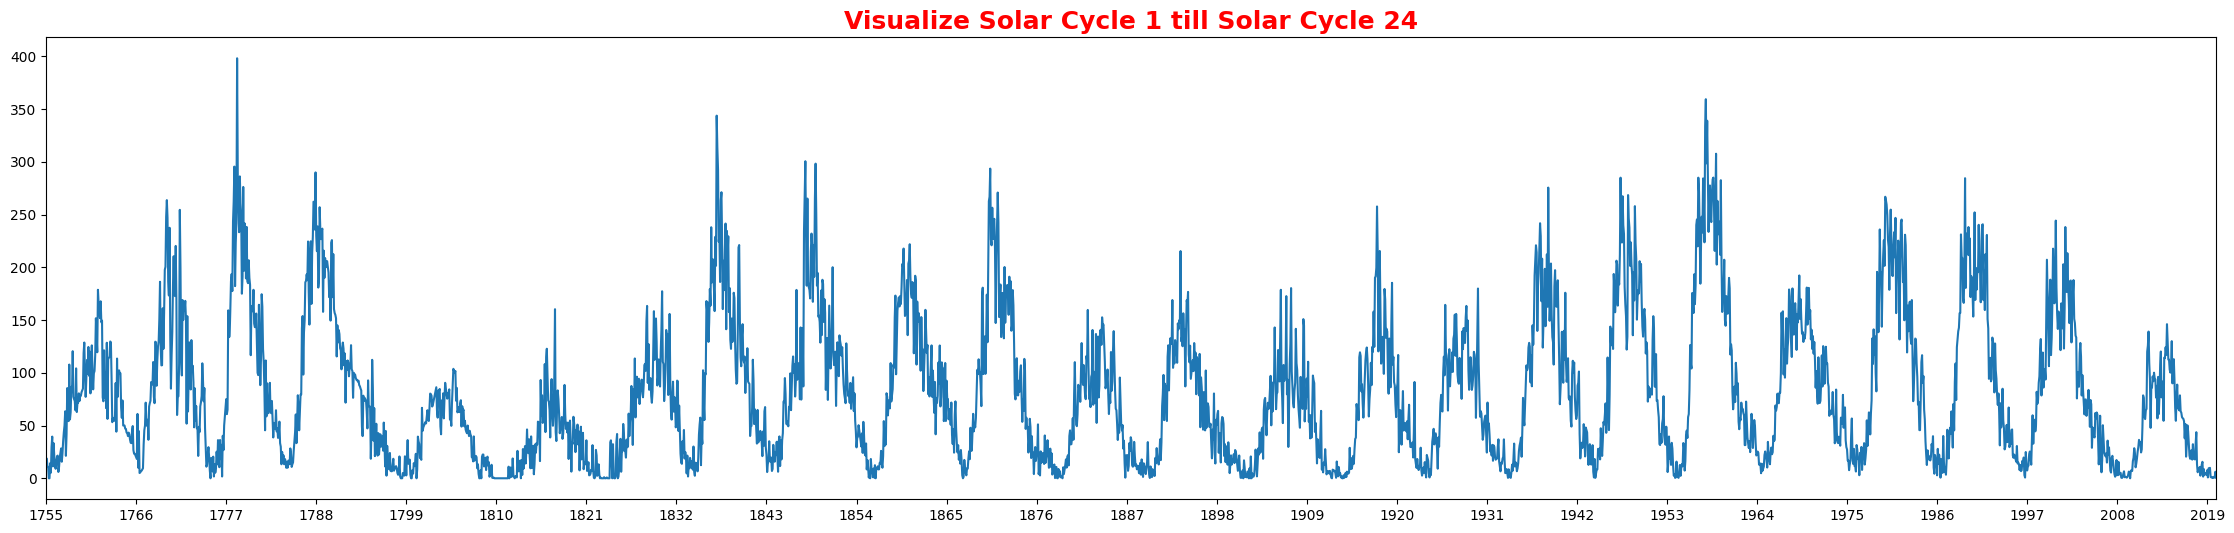

In [10]:
# Some changes for a better visualization of solar cycles
'''Collect all the years from 1755 to 2019 and use it as xticklabels'''
years = []
start = 1755
for i in range(0, len(data.iloc[:,-1][72:]),132):
    years.append(start)
    start+=11

plt.figure(figsize = (28, 6))
plt.plot(sunspots[72:])
plt.title("Visualize Solar Cycle 1 till Solar Cycle 24", weight = 'bold', color = 'r', fontsize = 18)
plt.xlim(72, 3265-12)
plt.xticks(range(72, len(sunspots),132))
plt.gca().set_xticklabels(years)
plt.show()

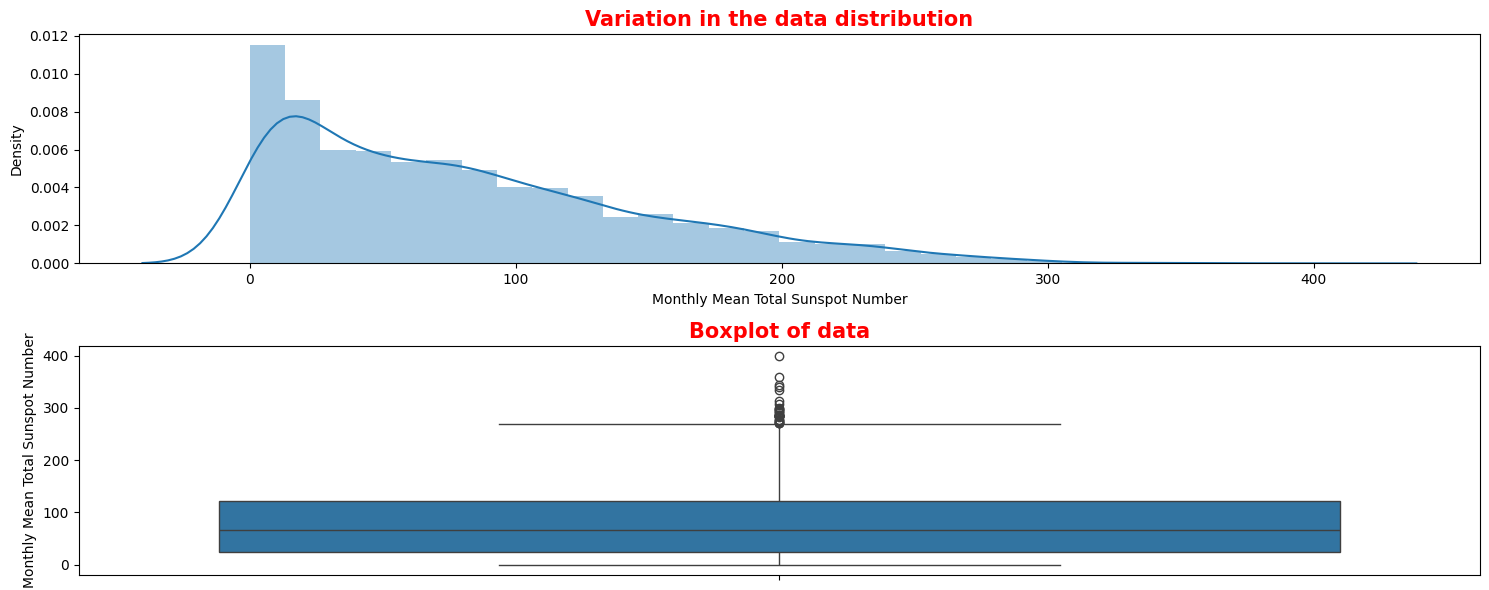

In [11]:
# Visualise the variation in the data distribution along with the outliers in the time series data
plt.figure(figsize = (15,6))
plt.subplot(2, 1, 1)
sns.distplot(sunspots)
plt.title("Variation in the data distribution", fontsize = 15, color = 'r', weight = 'bold')
plt.subplot(2, 1, 2)
sns.boxplot(sunspots)
plt.title("Boxplot of data", fontsize = 15, color = 'r', weight = 'bold')
plt.tight_layout()
plt.show()

In [12]:

#Helper function: Training data generation
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = series[:, np.newaxis]                                # Adding new dimension to the series array in the position where np.newaxis is written
    ds = tf.data.Dataset.from_tensor_slices(series)               # In order to use window of tensorflow convert numpy array to tensor
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # Creating window for generating sequence (yet not seperating it with the future values) - LSTM
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))          # Flatten a dataset of batches into a dataset of their elements
    ds = ds.shuffle(shuffle_buffer)                               # To reduce the variance and making sure that the model remain general and less overfits
    ds = ds.map(lambda w: (w[:-1], w[-1]))                        # In a window, last value is the future value that our model needs to learn and predict while testing it
    return ds.batch(batch_size).prefetch(1)                       # Prefetch one batch of data and make sure that there is always one ready

# Breaking down the above function

In [13]:
'''For example take the first 10 examples from the sunspots series'''
dum_series = sunspots[:10].values  # Numpy array 
dum_series, dum_series.shape       # Display array and its shape

(array([ 96.7, 104.3, 116.7,  92.8, 141.7, 139.2, 158. , 110.5, 126.5,
        125.8]),
 (10,))

In [14]:
'''Adding a new dimension in the place where np.axis is used'''
dum_series=dum_series[:, np.newaxis]   # Shape now should be 10x1 
dum_series, dum_series.shape           # Check

(array([[ 96.7],
        [104.3],
        [116.7],
        [ 92.8],
        [141.7],
        [139.2],
        [158. ],
        [110.5],
        [126.5],
        [125.8]]),
 (10, 1))

In [15]:
'''To use the window method of tensorflow to generate the sequence for LSTM we need to generate tensor from the numpy array'''
ds = tf.data.Dataset.from_tensor_slices(dum_series)  # Window method of tensorflow won't work on numpy array

# Display the content of the above dataset
for i in ds:  
    for val in i:
        print(val)

tf.Tensor(96.7, shape=(), dtype=float64)
tf.Tensor(104.3, shape=(), dtype=float64)
tf.Tensor(116.7, shape=(), dtype=float64)
tf.Tensor(92.8, shape=(), dtype=float64)
tf.Tensor(141.7, shape=(), dtype=float64)
tf.Tensor(139.2, shape=(), dtype=float64)
tf.Tensor(158.0, shape=(), dtype=float64)
tf.Tensor(110.5, shape=(), dtype=float64)
tf.Tensor(126.5, shape=(), dtype=float64)
tf.Tensor(125.8, shape=(), dtype=float64)


In [16]:
'''Generate sequence of length 3 ---> Hence prev 3 values will be used to train our model to learn and predict the 4th value'''
window_size = 3                                               # Sequence Length
ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # Drop remainder if True ensures the same shape of the tensor

# Display the changes
for i in ds:
    for val in i:
        print(val)

tf.Tensor([96.7], shape=(1,), dtype=float64)
tf.Tensor([104.3], shape=(1,), dtype=float64)
tf.Tensor([116.7], shape=(1,), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor([104.3], shape=(1,), dtype=float64)
tf.Tensor([116.7], shape=(1,), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor([116.7], shape=(1,), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor([158.], shape=(1,), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor([158.], shape=(1,), dtype=float64)
tf.Tensor([110.5], shape=(1,), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor([158.], shape=(1,), dtype=float

In [17]:
'''Flatten the dataset and map the function given in method argument across the dataset'''
ds = ds.flat_map(lambda w: w.batch(window_size + 1)) # Batch of 4 is what we want for this example
ds = ds.map(lambda w: (w[:-1], w[-1]))               # Two different outputs we should get ---> Sequence of 3 and 1 label

# Display the change
for i in ds:
    for val in i:
        print(val)

tf.Tensor(
[[ 96.7]
 [104.3]
 [116.7]], shape=(3, 1), dtype=float64)
tf.Tensor([92.8], shape=(1,), dtype=float64)
tf.Tensor(
[[104.3]
 [116.7]
 [ 92.8]], shape=(3, 1), dtype=float64)
tf.Tensor([141.7], shape=(1,), dtype=float64)
tf.Tensor(
[[116.7]
 [ 92.8]
 [141.7]], shape=(3, 1), dtype=float64)
tf.Tensor([139.2], shape=(1,), dtype=float64)
tf.Tensor(
[[ 92.8]
 [141.7]
 [139.2]], shape=(3, 1), dtype=float64)
tf.Tensor([158.], shape=(1,), dtype=float64)
tf.Tensor(
[[141.7]
 [139.2]
 [158. ]], shape=(3, 1), dtype=float64)
tf.Tensor([110.5], shape=(1,), dtype=float64)
tf.Tensor(
[[139.2]
 [158. ]
 [110.5]], shape=(3, 1), dtype=float64)
tf.Tensor([126.5], shape=(1,), dtype=float64)
tf.Tensor(
[[158. ]
 [110.5]
 [126.5]], shape=(3, 1), dtype=float64)
tf.Tensor([125.8], shape=(1,), dtype=float64)


In [18]:
'''Generate the final dataset for LSTM in shape of batch_size x sequence_length x #features and respective labels'''
ds = ds.batch(10).prefetch(1)  # sequence of length 3 for total of 10 examples means max_batch_size of 10 - 3 = 7 should be there
'''Shape of sequence data will be 7 x 3 x 1 and for labels it will be 7 x 1'''

# Display the final 3D Data
for i in ds:
    for val in i:
        print(val)
    print("\n")

tf.Tensor(
[[[ 96.7]
  [104.3]
  [116.7]]

 [[104.3]
  [116.7]
  [ 92.8]]

 [[116.7]
  [ 92.8]
  [141.7]]

 [[ 92.8]
  [141.7]
  [139.2]]

 [[141.7]
  [139.2]
  [158. ]]

 [[139.2]
  [158. ]
  [110.5]]

 [[158. ]
  [110.5]
  [126.5]]], shape=(7, 3, 1), dtype=float64)
tf.Tensor(
[[ 92.8]
 [141.7]
 [139.2]
 [158. ]
 [110.5]
 [126.5]
 [125.8]], shape=(7, 1), dtype=float64)




In [19]:
# Forecast would work in the same way where we provide the sequence and the output will be predicted by the model
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(batch_size).prefetch(1)
    forecast = model.predict(ds)  # To predict
    return forecast

# Train-Test Split

In [20]:
# Preparing the data
series = data['Monthly Mean Total Sunspot Number'].values
time = data['Unnamed: 0'].values

# Splitting the data into train and test 
split_time = int(len(series)*0.9)          # 90% of the original data is for training
time_train = time[:split_time]              
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
print(f"There are {len(x_train)} training samples and {len(x_valid)} validation samples.")

# Parameters
delta = 1                      # Huber loss
window_size = 60               # For dataset
batch_size = 145               # For dataset
shuffle_buffer_size= 900       # Shuffling the dataset randomly
epochs = 100                   # For optimal learning rate
train_epochs = epochs + 100    # Training epochs
momentum_sgd = 0.9             # For optimizer

There are 2938 training samples and 327 validation samples.


# Build the model and find the best learning rate to optimise model training

In [21]:
# To avoid clutter from old models and layers (in case of re-running the notebook without reset and resestart)
tf.keras.backend.clear_session()  

# To produce same sequence of results each time the code runs
tf.random.set_seed(42)
np.random.seed(42)

# Calling the window_dataset function to generate the training data
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Building the model
model = tf.keras.models.Sequential([
  # Conv1D layers smoothens out the input time-series so we don't have to add the rolling mean or rolling standard deviation values in the input features
  tf.keras.layers.Conv1D(filters=132, kernel_size=4,strides=1, padding="causal", activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(256, return_sequences=True), # Return sequence if set to true will return the outputs for each time step as explained above
  tf.keras.layers.LSTM(132, return_sequences=False),# Setting it as False will only output the last time step which will then be feeded into the fully connected layers
  tf.keras.layers.Dense(80, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),                         
  tf.keras.layers.Lambda(lambda x: x * 400)        # To push the values in the range of the original data after getting passed from different activations
]) 

# Display this model summary
model.summary()

# Using callbacks - Learning rate scheduler to find the optimal value to be used in the final model
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20), verbose = 0) # lr --> starting lr * 10^(0/20), starting lr * 10^(1/20), so on.. 

# Stochastic Gradient Desect as the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=momentum_sgd)
model.compile(loss=tf.keras.losses.Huber(delta),
              optimizer=optimizer,
              metrics=["mae"])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 132)         660       
                                                                 
 lstm (LSTM)                 (None, None, 256)         398336    
                                                                 
 lstm_1 (LSTM)               (None, 132)               205392    
                                                                 
 dense (Dense)               (None, 80)                10640     
                                                                 
 dense_1 (Dense)             (None, 10)                810       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 

In [22]:
history = model.fit(train_set, epochs=epochs, callbacks=[lr_schedule]) # Track the history of training

Epoch 1/100


20/20 [==============================] - 12s 371ms/step - loss: 96.1035 - mae: 96.6034 - lr: 1.0000e-08
Epoch 2/100
20/20 [==============================] - 7s 330ms/step - loss: 63.4339 - mae: 63.9333 - lr: 1.1220e-08
Epoch 3/100
20/20 [==============================] - 8s 381ms/step - loss: 40.1968 - mae: 40.6930 - lr: 1.2589e-08
Epoch 4/100
20/20 [==============================] - 8s 388ms/step - loss: 31.9286 - mae: 32.4241 - lr: 1.4125e-08
Epoch 5/100
20/20 [==============================] - 8s 371ms/step - loss: 29.3928 - mae: 29.8877 - lr: 1.5849e-08
Epoch 6/100
20/20 [==============================] - 8s 370ms/step - loss: 28.2398 - mae: 28.7352 - lr: 1.7783e-08
Epoch 7/100
20/20 [==============================] - 8s 369ms/step - loss: 27.3503 - mae: 27.8447 - lr: 1.9953e-08
Epoch 8/100
20/20 [==============================] - 8s 377ms/step - loss: 26.6192 - mae: 27.1147 - lr: 2.2387e-08
Epoch 9/100
20/20 [==============================] - 8s 373ms/step - loss: 25

In [23]:
# Learning rates used above
lrs = 1e-8 * (10**(np.arange(epochs)/20))
lrs

array([1.00000000e-08, 1.12201845e-08, 1.25892541e-08, 1.41253754e-08,
       1.58489319e-08, 1.77827941e-08, 1.99526231e-08, 2.23872114e-08,
       2.51188643e-08, 2.81838293e-08, 3.16227766e-08, 3.54813389e-08,
       3.98107171e-08, 4.46683592e-08, 5.01187234e-08, 5.62341325e-08,
       6.30957344e-08, 7.07945784e-08, 7.94328235e-08, 8.91250938e-08,
       1.00000000e-07, 1.12201845e-07, 1.25892541e-07, 1.41253754e-07,
       1.58489319e-07, 1.77827941e-07, 1.99526231e-07, 2.23872114e-07,
       2.51188643e-07, 2.81838293e-07, 3.16227766e-07, 3.54813389e-07,
       3.98107171e-07, 4.46683592e-07, 5.01187234e-07, 5.62341325e-07,
       6.30957344e-07, 7.07945784e-07, 7.94328235e-07, 8.91250938e-07,
       1.00000000e-06, 1.12201845e-06, 1.25892541e-06, 1.41253754e-06,
       1.58489319e-06, 1.77827941e-06, 1.99526231e-06, 2.23872114e-06,
       2.51188643e-06, 2.81838293e-06, 3.16227766e-06, 3.54813389e-06,
       3.98107171e-06, 4.46683592e-06, 5.01187234e-06, 5.62341325e-06,
      

In [24]:
# Fetch the optimum learning rate
min_loss = min(history.history['loss'])
idx_min_loss = history.history['loss'].index(min_loss)
opt_lr = lrs[idx_min_loss]
first = str(round(float(str(opt_lr).split('e')[0])))
second = str(opt_lr).split('e')[-1]
final = [first, second]
x = "e".join(final)
x = float(x)
print(f"Optimal Learning Rate was --> {x}.")

Optimal Learning Rate was --> 2e-06.


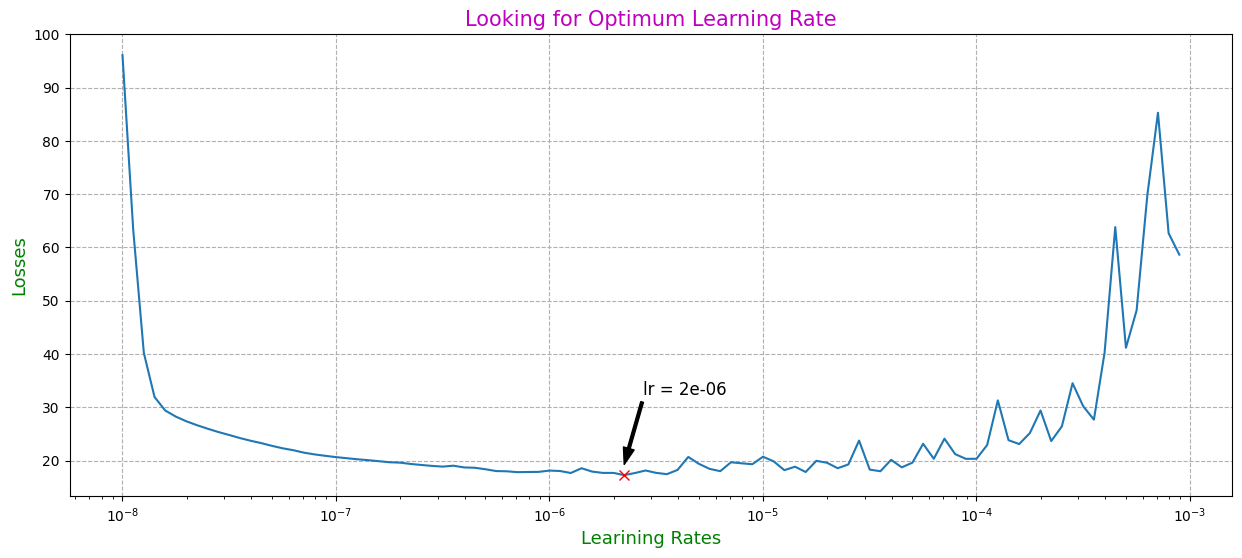

In [25]:
# Plot the output of Losses vs Learning Rates
fig = plt.figure(figsize=(15, 6))
plt.semilogx(lrs, history.history["loss"]) # Learning rates are increasing exponentially and hence for an omptimal sized plot we use semilogx plot
plt.grid(True, ls="--")
plt.plot(opt_lr,min_loss, color = 'r', marker = 'x', markersize = 7)
plt.title(f"Looking for Optimum Learning Rate", color = 'm', fontsize = 15)
plt.ylabel("Losses", fontsize = 13, color = 'g')
plt.xlabel("Learining Rates", fontsize = 13, color = 'g')
plt.annotate(f"lr = {x}", (opt_lr,min_loss+2), (opt_lr+0.05e-5, min_loss+15), arrowprops = dict(facecolor ='k', width = 2, headwidth = 8), fontsize = 12)
plt.show()

# Training the model with the Optimal Learning Rate

In [26]:
# Using the same steps to build the model but now with the optimal learning rate to train it
tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=132, kernel_size=4,strides=1, padding="causal", activation="relu",input_shape=[None, 1]),
  tf.keras.layers.LSTM(256, return_sequences=True),
  tf.keras.layers.LSTM(132, return_sequences=False),
  tf.keras.layers.Dense(80, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=opt_lr, momentum=momentum_sgd)
model.compile(loss=tf.keras.losses.Huber(delta),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=train_epochs)

Epoch 1/200
20/20 [==============================] - 11s 353ms/step - loss: 38.1841 - mae: 38.6806
Epoch 2/200
20/20 [==============================] - 8s 407ms/step - loss: 20.7256 - mae: 21.2201
Epoch 3/200
20/20 [==============================] - 8s 409ms/step - loss: 19.0810 - mae: 19.5734
Epoch 4/200
20/20 [==============================] - 8s 414ms/step - loss: 17.9921 - mae: 18.4847
Epoch 5/200
20/20 [==============================] - 8s 409ms/step - loss: 18.1787 - mae: 18.6710
Epoch 6/200
20/20 [==============================] - 9s 453ms/step - loss: 18.7194 - mae: 19.2123
Epoch 7/200
20/20 [==============================] - 8s 401ms/step - loss: 19.1446 - mae: 19.6371
Epoch 8/200
20/20 [==============================] - 8s 381ms/step - loss: 19.3863 - mae: 19.8801
Epoch 9/200
20/20 [==============================] - 8s 393ms/step - loss: 19.7046 - mae: 20.1978
Epoch 10/200
20/20 [==============================] - 9s 434ms/step - loss: 18.4871 - mae: 18.9791
Epoch 11/200
20/20

# Plots, Results and Predictions

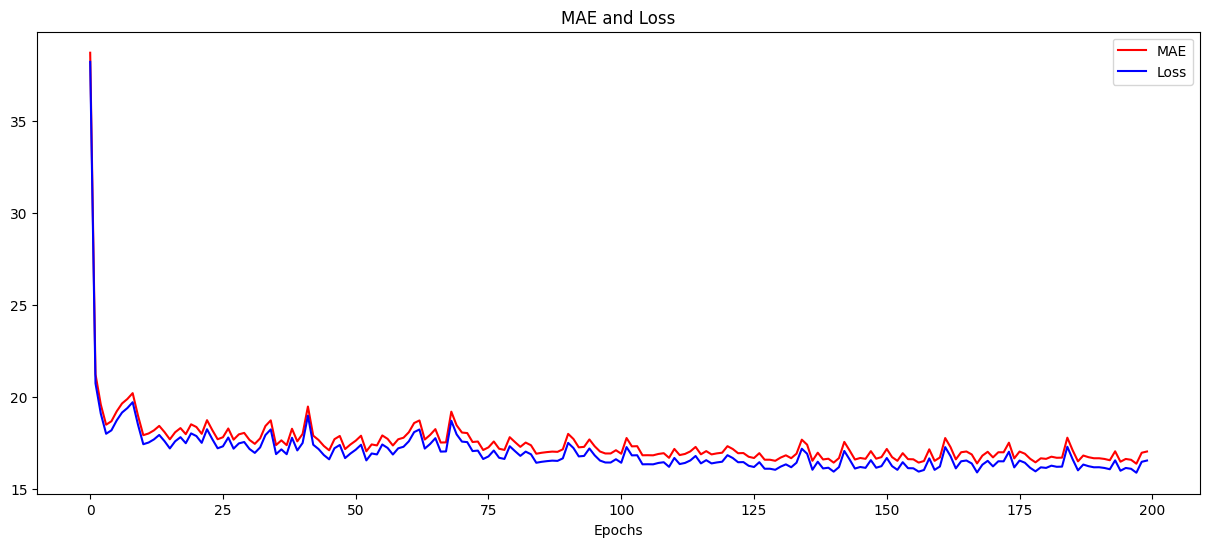

In [27]:
# Fetch the MAE and Huber Loss from the history
mae=history.history['mae']
loss=history.history['loss']

# Plot MAE and Huber Loss
fig = plt.figure(figsize=(15, 6))
plt.plot(mae, 'r')
plt.plot(loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.legend(["MAE", "Loss"])

23/23 [==============================] - 20s 308ms/step


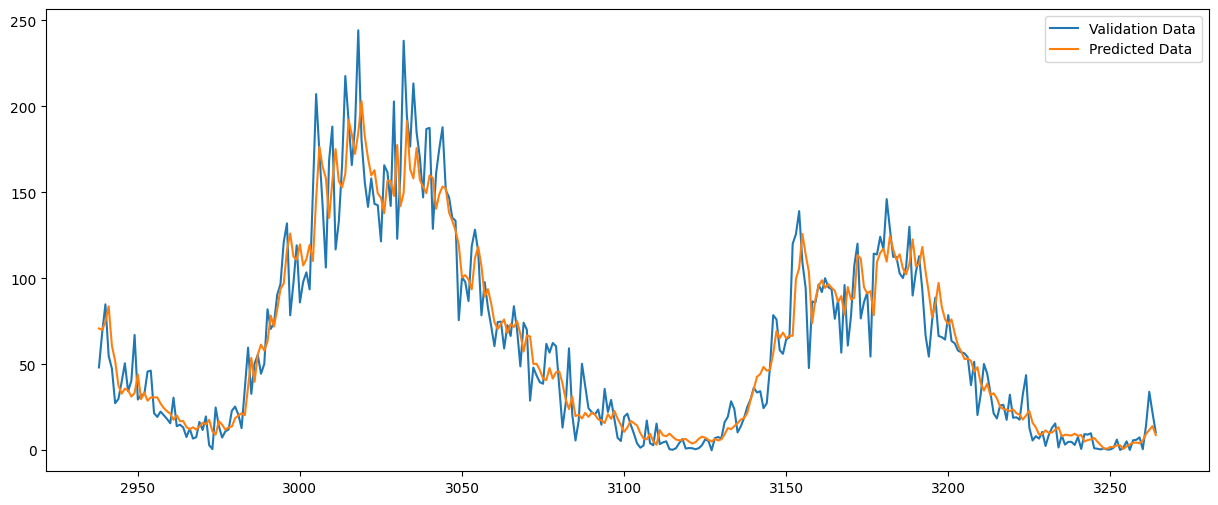

In [28]:
# Call the model_forecast here and display the plots of validation and prediction
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, 0]  # rnn_forecast[-328:-1, 0]

# Plots
plt.figure(figsize=(15, 6))
plt.plot(time_valid, x_valid)
plt.plot(time_valid, rnn_forecast)
plt.title("")
plt.legend(["Validation Data", "Predicted Data"])
plt.show()

In [29]:
# Validation MAE
val_mae=tf.keras.metrics.mae(x_valid, rnn_forecast).numpy()
print(f"MAE on the validation data:- {val_mae}")

MAE on the validation data:- 12.235224723815918
